In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import os
import re
import spacy
import ast
from geopy.distance import geodesic
from datetime import datetime, date
nlp = spacy.load('en')
from collections import Counter
%matplotlib inline

In [2]:
list_df = pd.read_csv('./archive/listings.csv')
cal_df = pd.read_csv('./archive/calendar.csv')
review_df = pd.read_csv('./archive/reviews.csv')

We want to determine what features a listing must have to generate the highest price point. Features examined will be neighbourhood, amenities included, and rating

- What style of accommodation  allows for highest revenue?
- Can we predict price using categorical and quantitative values?
- What effect does distance from city center have on price?

The listings dataset contains the fields of interest in analyzing the dataset. The calendar and reviews csv files are not needed for the purpose of this project. The following cell analyzed the size and data types contained in the file.

In [3]:
print('Shape:', list_df.shape)
print('Data types column count:')
print(list_df.dtypes.value_counts())

Shape: (3818, 92)
Data types column count:
object     62
float64    17
int64      13
dtype: int64


The dataset contains entries for 3818 listings with 92 variables per listing. These variables are represented by a mix of object, float64, and int64 data types. This indicates that a mix of quantitative and categorical variables can be found for each listing, complicating our analysis of the data.

Now that the types of data contained in the dataset are known, it is important to analyze missing values in the dataset. This will aid in determining which columns might not be useful in our analysis due to a lack of entries.

In [4]:
#Count the number of missing values and then sort in descending order
#pd.set_option("max_rows", None)
list_df.isna().sum().sort_values(ascending=False)

license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
                    ... 
accommodates           0
bed_type               0
amenities              0
price                  0
id                     0
Length: 92, dtype: int64

The missing values in some of these columns will need to be dealt with to accurately analyze the data. Certain columns containing missing values are not of interest, contain over 50 % missing values without an explanation, or are categorical variables containing a written description that is not within the scope of our analysis. These columns dropped completely (license, notes, neighborhood_overview, transit, host_about, first_review, last_review, space, any of the url vairables, summary, host_location). Monthly and weekly price variables will be dropped considering the price variable encompasses these values and is more universally listed in the dataset. Security_deposit, cleaning_fee, and extra_people are all columns that contain fee information where an absent value is likely an indication of a zero $ fee and the missing value will be replaced with 0. All other columns with missing values will have the missing entries filled with mean or mode values.

### Data Transformations

The quantitative and categorical columns of interest are separated.

In [6]:
quantitative = ['host_since', 'host_response_rate', 'host_acceptance_rate',
       'host_total_listings_count', 'accommodates', 'price', 'availability_365',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']

categorical = ['host_verifications', 'amenities','host_response_time','host_is_superhost',  
       'host_identity_verified', 'property_type', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy', 
       'require_guest_profile_picture', 'require_guest_phone_verification', 'neighbourhood_group_cleansed',
       'requires_license', 'is_location_exact', 'has_availability']

# 'neighbourhood_cleansed', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'host_has_profile_pic',

In [7]:
drop_list = [i for i in list_df.columns if i not in quantitative+categorical]

In [8]:
test_df = list_df.drop(drop_list, axis=1)    

Certain columns that belong to each group must be transformed for accurate analysis. Columns in the date_cols category are in the format of "YYYY-MM-DD" as strings and must be transformed into a numerical count of the days since the indicated date. This quantitative variable should allow for meaningful information to be extracted as the larger the number, the more time has passed. Columns in the value_cols category are given as prices including dollar signs in a string format. These must be converted to floats to be analyzed. The rest of the quantitative variables (in num_cols) are already in float or int format and need no conversion.

list_cols indicates the categorical columns that contain a string list of values. These entries must be converted to a list and then each possible amenity or verification will be made into a single column with a 1 or 0 value for whether a listing contains that amenity/verification. This is necessary as creating dummy variables from the list entries would create dummy columns for each separate possible list, regardless of the amenities/verifications contained within that list.

In [9]:
date_cols = ['host_since']
value_cols = ['host_response_rate', 'host_acceptance_rate',
              'price', 'extra_people', 'security_deposit', 'cleaning_fee']

#columns in which a nan value represents a zero $ fee
nan_zero_cols = ['cleaning_fee', 'extra_people'] 

#columns in which nan values will be filled with the mode rather than the mean as a float value would not be realistic
nan_mode_cols = ['host_total_listings_count', 'accommodates',
               'bathrooms', 'bedrooms', 'beds','minimum_nights',
               'maximum_nights', 
               'availability_365', 'number_of_reviews'] 

num_cols = [i for i in quantitative if i not in date_cols+value_cols]

list_cols = ['host_verifications', 'amenities']
cat_cols = [i for i in categorical if i not in list_cols]

In [10]:
#reformat_date takes in a list of column names containing entries in a date format and replaces them with 
#a number of days since the date using the datetime library
def reformat_date(df, date_vars):
    for col in date_vars:
        for i in df[col].index:
            if not pd.isnull(df[col][i]):
                delta = date.today() - date.fromisoformat(df[col][i])
                df.loc[i, col] = delta.days
        df.loc[:, col] = df[col].astype(float)
        
    return df

test_df = reformat_date(test_df, date_cols)

In [12]:
#reformat_price takes in a list of column names containing entries in a price string format and replaces them with 
#a float value
def reformat_price(df, value_vars):
    for col in value_vars:
        for i in df[col].index:
            if not pd.isnull(df[col][i]):
                df.loc[i, col] = re.sub("[$,%]", "", df[col][i])
        df.loc[:, col] = df[col].astype(float)
    
    return df

test_df = reformat_price(test_df, value_cols)
list_df = reformat_price(list_df, value_cols)

In [13]:
#reformat_list takes in a list of column names containing entries in a string list format and replaces them with a 
#basic list that is then used to create dummy columns for each possible list entry value
def reformat_list(df, list_vars):
    for col in list_vars:
        new_col = []
        for i in df[col].index:
            if not pd.isnull(df[col][i]):
                if '{' in df[col][i]:
                    new_col.append(df[col][i].strip('{}').split(','))
                else:
                    new_col.append(ast.literal_eval(df[col][i]))
            else:
                new_col.append([])
        df = df.drop(col, axis=1)
        df = df.assign(temp=pd.Series(new_col).values)
        df = pd.concat([df.drop('temp', axis=1), pd.get_dummies(df['temp'].apply(pd.Series).stack()).sum(level=0)], axis=1)
    return df

test_df = reformat_list(test_df, list_cols)

In [14]:
#fill_null fills in all null values in the quantitative columns with the mean of the column, the mode, or a zero value
def fill_null(df, mode_cols, zero_cols):
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        if col in zero_cols:
            df.loc[:, col].fillna(0, inplace=True)
        elif col in mode_cols:
            df.loc[:, col].fillna((df[col].mode()[0]), inplace=True)
        else:
            df.loc[:, col].fillna((df[col].mean()), inplace=True)
    return df

test_df = fill_null(test_df, nan_mode_cols, nan_zero_cols)

In [15]:
def dummy_columns(df, cat_vars):
    for col in cat_vars:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], 
                 prefix=col, prefix_sep='_', dummy_na=False, drop_first=True)], axis=1)
        except:
            continue
    return df

test_df = dummy_columns(test_df, cat_cols)

In [16]:
y = test_df['price']
X = test_df.drop(['price', ''], axis=1)    

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=28) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.6446707430768346 on 1146 values.'

In [22]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df

,est_int,coefs,abs_coefs
98,property_type_Treehouse,93.186283,93.186283
86,property_type_Boat,92.859919,92.859919
101,room_type_Shared room,-70.657865,70.657865
94,property_type_Loft,41.787917,41.787917
100,room_type_Private room,-40.995074,40.995074
...,...,...,...
9,security_deposit,0.030974,0.030974
8,square_feet,0.010549,0.010549
0,host_since,-0.004679,0.004679
13,minimum_nights,-0.002476,0.002476


In [38]:
new_col = []
for i in list_df['price'].index:
    if not pd.isnull(list_df['price'][i]):
        new_col.append(list_df['price'][i]*(365 - list_df['availability_365'][i]))
    else:
        new_col.append([])

list_df = list_df.assign(revenue=pd.Series(new_col).values)

In [23]:
list_df.groupby(['property_type'])['price'].mean().sort_values(ascending=False)

property_type
Boat               282.375000
Condominium        151.109890
Loft               135.700000
House              132.351414
Townhouse          129.457627
Apartment          122.932670
Camper/RV          120.461538
Bungalow           115.615385
Bed & Breakfast    112.054054
Cabin              104.666667
Treehouse          101.000000
Yurt               100.000000
Chalet              98.500000
Other               94.681818
Tent                54.000000
Dorm                39.500000
Name: price, dtype: float64

In [24]:
avail_srs = list_df.groupby(['property_type'])['availability_365'].mean().sort_values(ascending=False)
price_srs = list_df.groupby(['property_type'])['price'].mean().sort_values(ascending=False)

rev_dict = {}
for i in avail_srs.index:
    rev_dict[i] = (365 - avail_srs[i]) * price_srs[i]

rev_srs = pd.Series(rev_dict).sort_values(ascending=False)
rev_srs

Condominium        23229.409371
Boat               22766.484375
Yurt               18800.000000
Townhouse          17460.323183
Loft               15975.282500
Apartment          15533.348944
House              14961.437597
Treehouse          14207.333333
Cabin              12874.000000
Bungalow           12788.840237
Camper/RV          12250.011834
Bed & Breakfast    11032.781592
Tent               10270.800000
Dorm                6004.000000
Other               4639.409091
Chalet              3152.000000
dtype: float64

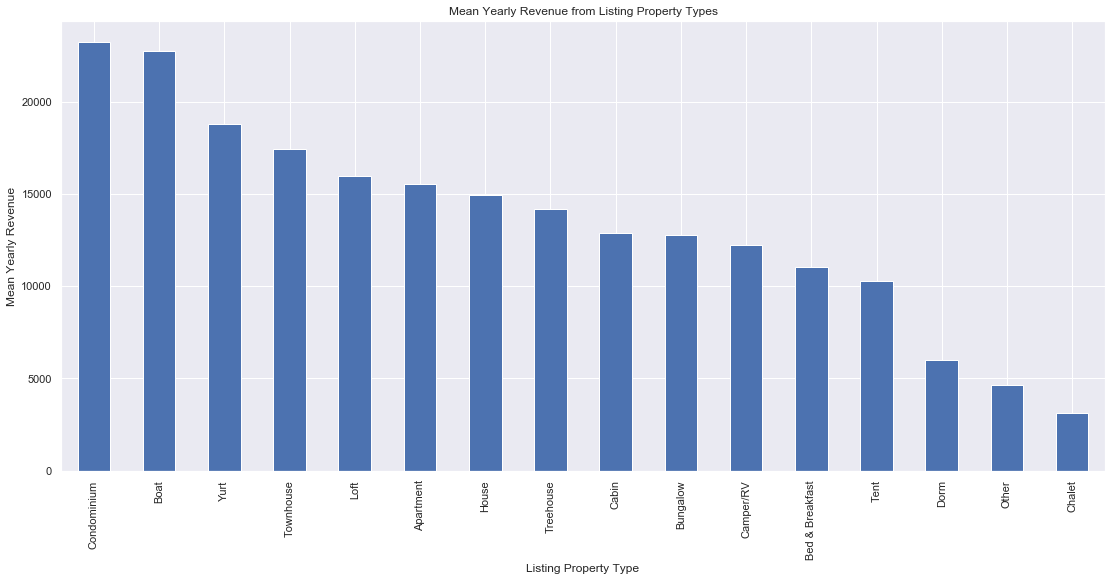

In [77]:
rev_srs.plot(kind='bar', legend=None)
sns.set(rc={'figure.figsize':(8.7,4.27)})
plt.title('Mean Yearly Revenue from Listing Property Types')
plt.xlabel('Listing Property Type')
plt.ylabel('Mean Yearly Revenue')
plt.show()

In [526]:
coocoo = (list_df['latitude'][3], list_df['longitude'][3])

(47.63847320176642, -122.36927912263019)

In [543]:


coords_1 = coocoo
coords_dt = (47.605141, -122.334289)

print(geodesic(coords_1, coords_dt).km)

4.543728961698944


In [29]:
new_col = []
coords_dt = (47.605149, -122.334289)
for i in list_df.index:
    if not pd.isnull(list_df['latitude'][i]) and not pd.isnull(list_df['longitude'][i]):
        coords = (list_df['latitude'][i], list_df['longitude'][i])
        new_col.append(geodesic(coords, coords_dt).km)
    else:
        new_col.append([])

list_df = list_df.assign(distance_from_dt=pd.Series(new_col).values)

In [649]:
BLA = test_df.drop(test_df.index[test_df['revenue'] == 0], inplace = True)

Text(0.5, 0, 'Distance from Downtown Seattle (km)')

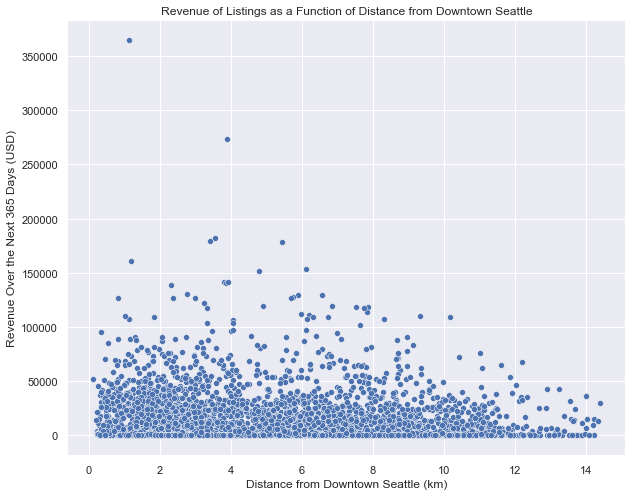

In [74]:
ax = sns.scatterplot(x='distance_from_dt', y='revenue', data=list_df)
sns.set(rc={'figure.figsize':(14, 8)})         
ax.set_title('Revenue of Listings as a Function of Distance from Downtown Seattle')
ax.set_ylabel('Revenue Over the Next 365 Days (USD)')
ax.set_xlabel('Distance from Downtown Seattle (km)')

In [60]:
price_dict = {}
for col in test_df.columns[pd.Series(test_df.columns).str.startswith('property')]:
    price_dict[col] = 0
    for i in test_df[col].index:
        if test_df[col][i] == 1:
            price_dict[col] += (test_df['price'][i] * (365 - test_df['availability_365'][i]))

In [43]:
price_dict

{'property_type_Bed & Breakfast': 383453.0,
 'property_type_Boat': 73105.0,
 'property_type_Bungalow': 141210.0,
 'property_type_Cabin': 232274.0,
 'property_type_Camper/RV': 138724.0,
 'property_type_Chalet': 8640.0,
 'property_type_Condominium': 1976192.0,
 'property_type_Dorm': 12395.0,
 'property_type_House': 27892463.0,
 'property_type_Loft': 700289.0,
 'property_type_Other': 89439.0,
 'property_type_Tent': 48260.0,
 'property_type_Townhouse': 2065544.0,
 'property_type_Treehouse': 67290.0,
 'property_type_Yurt': 18800.0}

Text(0.5, 0, 'Listing Property Type')

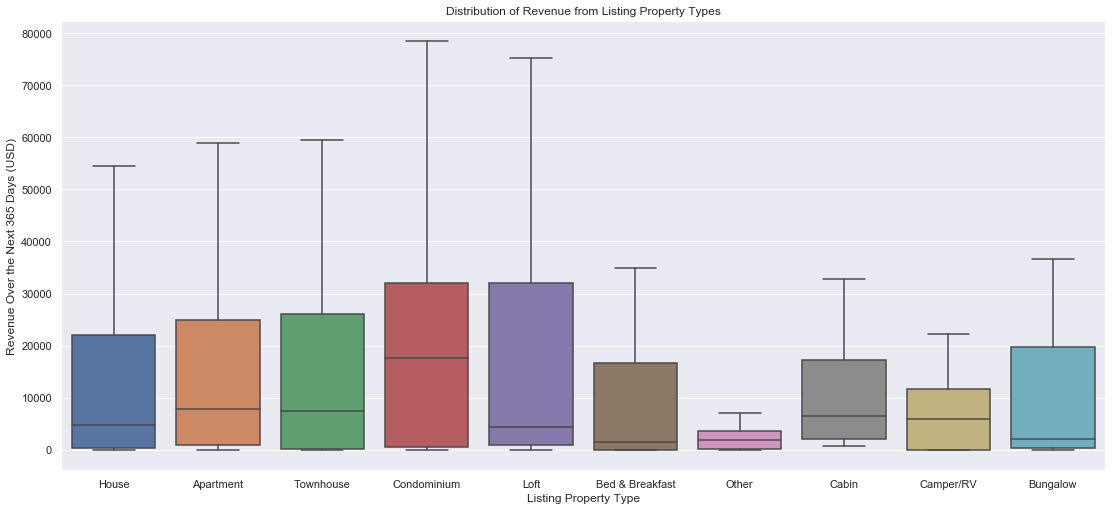

In [78]:
sns.set_theme(style="dark")
sns.set(rc={'figure.figsize':(18.7,8.27)})

ax = sns.boxplot(x="property_type", y="revenue", data=list_df, order = viable, showfliers=False)
ax.set_title('Distribution of Revenue from Listing Property Types')
ax.set_ylabel('Revenue Over the Next 365 Days (USD)')
ax.set_xlabel('Listing Property Type')


In [36]:
viable = []
for i in list_df['property_type'].value_counts().index:
    if list_df['property_type'].value_counts()[i] >= 10:
        viable.append(i)
        
viable

['House',
 'Apartment',
 'Townhouse',
 'Condominium',
 'Loft',
 'Bed & Breakfast',
 'Other',
 'Cabin',
 'Camper/RV',
 'Bungalow']